In [1]:
import gc
import sys
import os
import warnings

sys.path.append(os.path.abspath("modules/"))
sys.path.append(os.path.abspath("fe_modules/"))
sys.path.append(os.path.abspath("seq2seq_modules/"))

os.environ['OPENBLAS_NUM_THREADS'] = '1'
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import time
import polars as pl
import scipy
import implicit
import bisect
import sklearn.metrics as m
from catboost import CatBoostClassifier, CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve, CalibratedClassifierCV

In [3]:
import importlib

import modules
import fe_modules

importlib.reload(modules)
importlib.reload(fe_modules)

from modules.memory_utils import pandas_reduce_mem_usage, pandas_string_to_cat, my_reset
from fe_modules.text_manipulation import get_domain
from fe_modules.datetime_features import get_timestamp, get_relative_time, part_of_day_to_hour, add_hour_to_date
from fe_modules.preprocessing import clean_os_type

# Load data

In [4]:
LOCAL_DATA_PATH = './data/'
SPLIT_SEED = 42

In [5]:
df = pandas_reduce_mem_usage( 
        pd.read_parquet(
            f'{LOCAL_DATA_PATH}competition_data_final_pqt/'
    ))
df

Memory usage of dataframe is 29562.33 MB


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.33it/s]

Memory usage after optimization is: 24943.21 MB
Decreased by 15.6%


,region_name,city_name,cpe_manufacturer_name,cpe_model_name,url_host,cpe_type_cd,cpe_model_os_type,price,date,part_of_day,request_cnt,user_id
0,Краснодарский край,Краснодар,Apple,iPhone 7,ad.adriver.ru,smartphone,iOS,20368.0,2022-06-15,morning,1,45098
1,Краснодарский край,Краснодар,Apple,iPhone 7,apple.com,smartphone,iOS,20368.0,2022-06-19,morning,1,45098
2,Краснодарский край,Краснодар,Apple,iPhone 7,avatars.mds.yandex.net,smartphone,iOS,20368.0,2022-06-12,day,1,45098
3,Краснодарский край,Краснодар,Apple,iPhone 7,googleads.g.doubleclick.net,smartphone,iOS,20368.0,2022-05-16,day,1,45098
4,Краснодарский край,Краснодар,Apple,iPhone 7,googleads.g.doubleclick.net,smartphone,iOS,20368.0,2022-05-30,day,1,45098
...,...,...,...,...,...,...,...,...,...,...,...,...
322899430,Калужская область,Обнинск,Samsung,Galaxy A30s Dual,avatars.mds.yandex.net,smartphone,Android,16376.0,2021-07-12,morning,1,300964
322899431,Калужская область,Обнинск,Samsung,Galaxy A30s Dual,googleads.g.doubleclick.net,smartphone,Android,16376.0,2021-06-20,evening,1,300964
322899432,Калужская область,Обнинск,Samsung,Galaxy A30s Dual,online.sberbank.ru,smartphone,Android,16376.0,2021-08-05,day,1,300964
322899433,Калужская область,Обнинск,Samsung,Galaxy A30s Dual,s0.2mdn.net,smartphone,Android,16376.0,2021-07-19,evening,1,300964


In [6]:
target = pandas_reduce_mem_usage(
    pd.read_parquet(
        f'{LOCAL_DATA_PATH}public_train.pqt'
    ))
target

Memory usage of dataframe is 8.24 MB


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 911.41it/s]

Memory usage after optimization is: 5.66 MB
Decreased by 31.2%


,age,is_male,user_id
350459,31.0,1,350459
188276,35.0,1,188276
99002,41.0,0,99002
155506,33.0,0,155506
213873,54.0,0,213873
...,...,...,...
225374,49.0,1,225374
25776,22.0,1,25776
148131,28.0,0,148131
205570,28.0,1,205570


# Feature engeneering

## Cleaning

In [7]:
df = clean_os_type(df)
df.head()

,region_name,city_name,cpe_manufacturer_name,cpe_model_name,url_host,cpe_type_cd,cpe_model_os_type,price,date,part_of_day,request_cnt,user_id
0,Краснодарский край,Краснодар,Apple,iPhone 7,ad.adriver.ru,smartphone,iOS,20368.0,2022-06-15,morning,1,45098
1,Краснодарский край,Краснодар,Apple,iPhone 7,apple.com,smartphone,iOS,20368.0,2022-06-19,morning,1,45098
2,Краснодарский край,Краснодар,Apple,iPhone 7,avatars.mds.yandex.net,smartphone,iOS,20368.0,2022-06-12,day,1,45098
3,Краснодарский край,Краснодар,Apple,iPhone 7,googleads.g.doubleclick.net,smartphone,iOS,20368.0,2022-05-16,day,1,45098
4,Краснодарский край,Краснодар,Apple,iPhone 7,googleads.g.doubleclick.net,smartphone,iOS,20368.0,2022-05-30,day,1,45098


## Feature generation

In [8]:
df = pandas_string_to_cat(df, 
                            ["region_name", 
                             "city_name", 
                             "cpe_manufacturer_name", 
                             "cpe_model_name",
                             "cpe_type_cd", 
                             "cpe_model_os_type",
                            ]
                           )
df.head()

Memory usage of dataframe is 24943.21 MB
Memory usage of dataframe is 24.36 GB


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:30<00:00, 15.15s/it]

Memory usage after optimization is: 12625.58 MB
Decreased by 49.4%


,region_name,city_name,cpe_manufacturer_name,cpe_model_name,url_host,cpe_type_cd,cpe_model_os_type,price,date,part_of_day,request_cnt,user_id
0,21,409,1,589,ad.adriver.ru,2,1,20368.0,2022-06-15,morning,1,45098
1,21,409,1,589,apple.com,2,1,20368.0,2022-06-19,morning,1,45098
2,21,409,1,589,avatars.mds.yandex.net,2,1,20368.0,2022-06-12,day,1,45098
3,21,409,1,589,googleads.g.doubleclick.net,2,1,20368.0,2022-05-16,day,1,45098
4,21,409,1,589,googleads.g.doubleclick.net,2,1,20368.0,2022-05-30,day,1,45098


In [9]:
df = get_domain(df)
df.head()

,region_name,city_name,cpe_manufacturer_name,cpe_model_name,url_host,cpe_type_cd,cpe_model_os_type,price,date,part_of_day,request_cnt,user_id,domain
0,21,409,1,589,ad.adriver.ru,2,1,20368.0,2022-06-15,morning,1,45098,ru
1,21,409,1,589,apple.com,2,1,20368.0,2022-06-19,morning,1,45098,com
2,21,409,1,589,avatars.mds.yandex.net,2,1,20368.0,2022-06-12,day,1,45098,net
3,21,409,1,589,googleads.g.doubleclick.net,2,1,20368.0,2022-05-16,day,1,45098,net
4,21,409,1,589,googleads.g.doubleclick.net,2,1,20368.0,2022-05-30,day,1,45098,net


In [10]:
df = pandas_string_to_cat(df, 
                            [
                            "domain",
                            "url_host"
                            ]
                           )
df.head()

Memory usage of dataframe is 17552.63 MB
Memory usage of dataframe is 17.14 GB


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:23<00:00, 11.83s/it]

Memory usage after optimization is: 14473.22 MB
Decreased by 17.5%


,region_name,city_name,cpe_manufacturer_name,cpe_model_name,url_host,cpe_type_cd,cpe_model_os_type,price,date,part_of_day,request_cnt,user_id,domain
0,21,409,1,589,5788,2,1,20368.0,2022-06-15,morning,1,45098,761
1,21,409,1,589,12900,2,1,20368.0,2022-06-19,morning,1,45098,549
2,21,409,1,589,17626,2,1,20368.0,2022-06-12,day,1,45098,712
3,21,409,1,589,59366,2,1,20368.0,2022-05-16,day,1,45098,712
4,21,409,1,589,59366,2,1,20368.0,2022-05-30,day,1,45098,712


In [11]:
df.dtypes

region_name                uint8
city_name                 uint16
cpe_manufacturer_name      uint8
cpe_model_name            uint16
url_host                  uint32
cpe_type_cd                uint8
cpe_model_os_type          uint8
price                    float32
date                      object
part_of_day               object
request_cnt                 int8
user_id                    int32
domain                    uint16
dtype: object

In [12]:
df = pandas_reduce_mem_usage(get_timestamp(df))
df.head()

Memory usage of dataframe is 16936.75 MB


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:02<00:00,  5.30it/s]

Memory usage after optimization is: 15704.99 MB
Decreased by 7.3%


,region_name,city_name,cpe_manufacturer_name,cpe_model_name,url_host,cpe_type_cd,cpe_model_os_type,price,date,part_of_day,request_cnt,user_id,domain,timestamp
0,21,409,1,589,5788,2,1,20368.0,2022-06-15,morning,1,45098,761,165525120.0
1,21,409,1,589,12900,2,1,20368.0,2022-06-19,morning,1,45098,549,165559680.0
2,21,409,1,589,17626,2,1,20368.0,2022-06-12,day,1,45098,712,165499200.0
3,21,409,1,589,59366,2,1,20368.0,2022-05-16,day,1,45098,712,165265920.0
4,21,409,1,589,59366,2,1,20368.0,2022-05-30,day,1,45098,712,165386880.0


In [13]:
df = part_of_day_to_hour(df)
df.head()

,region_name,city_name,cpe_manufacturer_name,cpe_model_name,url_host,cpe_type_cd,cpe_model_os_type,price,date,part_of_day,request_cnt,user_id,domain,timestamp,hour
0,21,409,1,589,5788,2,1,20368.0,2022-06-15,morning,1,45098,761,165525120.0,0 days 09:00:00
1,21,409,1,589,12900,2,1,20368.0,2022-06-19,morning,1,45098,549,165559680.0,0 days 09:00:00
2,21,409,1,589,17626,2,1,20368.0,2022-06-12,day,1,45098,712,165499200.0,0 days 15:00:00
3,21,409,1,589,59366,2,1,20368.0,2022-05-16,day,1,45098,712,165265920.0,0 days 15:00:00
4,21,409,1,589,59366,2,1,20368.0,2022-05-30,day,1,45098,712,165386880.0,0 days 15:00:00


In [14]:
df = add_hour_to_date(df)
df.head()

,region_name,city_name,cpe_manufacturer_name,cpe_model_name,url_host,cpe_type_cd,cpe_model_os_type,price,date,part_of_day,request_cnt,user_id,domain,timestamp,hour,datetime
0,21,409,1,589,5788,2,1,20368.0,2022-06-15,morning,1,45098,761,165525120.0,0 days 09:00:00,2022-06-15 09:00:00
1,21,409,1,589,12900,2,1,20368.0,2022-06-19,morning,1,45098,549,165559680.0,0 days 09:00:00,2022-06-19 09:00:00
2,21,409,1,589,17626,2,1,20368.0,2022-06-12,day,1,45098,712,165499200.0,0 days 15:00:00,2022-06-12 15:00:00
3,21,409,1,589,59366,2,1,20368.0,2022-05-16,day,1,45098,712,165265920.0,0 days 15:00:00,2022-05-16 15:00:00
4,21,409,1,589,59366,2,1,20368.0,2022-05-30,day,1,45098,712,165386880.0,0 days 15:00:00,2022-05-30 15:00:00


In [15]:
df = get_relative_time(df, return_dtype="timestamp")
df.head()

,region_name,city_name,cpe_manufacturer_name,cpe_model_name,url_host,cpe_type_cd,cpe_model_os_type,price,date,part_of_day,request_cnt,user_id,domain,timestamp,hour,datetime,relative_date
0,21,409,1,589,5788,2,1,20368.0,2022-06-15,morning,1,45098,761,165525120.0,0 days 09:00:00,2022-06-15 09:00:00,3888.0
1,21,409,1,589,12900,2,1,20368.0,2022-06-19,morning,1,45098,549,165559680.0,0 days 09:00:00,2022-06-19 09:00:00,432.0
2,21,409,1,589,17626,2,1,20368.0,2022-06-12,day,1,45098,712,165499200.0,0 days 15:00:00,2022-06-12 15:00:00,6264.0
3,21,409,1,589,59366,2,1,20368.0,2022-05-16,day,1,45098,712,165265920.0,0 days 15:00:00,2022-05-16 15:00:00,29592.0
4,21,409,1,589,59366,2,1,20368.0,2022-05-30,day,1,45098,712,165386880.0,0 days 15:00:00,2022-05-30 15:00:00,17496.0


In [17]:
df = pandas_string_to_cat(df, 
                            [
                            "part_of_day"
                            ]
                           )
df.head()

Memory usage of dataframe is 15704.99 MB
Memory usage of dataframe is 15.34 GB


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.11s/it]

Memory usage after optimization is: 13549.40 MB
Decreased by 13.7%


,region_name,city_name,cpe_manufacturer_name,cpe_model_name,url_host,cpe_type_cd,cpe_model_os_type,price,part_of_day,request_cnt,user_id,domain,timestamp,relative_date
0,21,409,1,589,5788,2,1,20368.0,2,1,45098,761,165525120.0,3888.0
1,21,409,1,589,12900,2,1,20368.0,2,1,45098,549,165559680.0,432.0
2,21,409,1,589,17626,2,1,20368.0,0,1,45098,712,165499200.0,6264.0
3,21,409,1,589,59366,2,1,20368.0,0,1,45098,712,165265920.0,29592.0
4,21,409,1,589,59366,2,1,20368.0,0,1,45098,712,165386880.0,17496.0


In [18]:
df = df.drop(labels=["date", "hour", "datetime"], axis=1)
df.head()

,region_name,city_name,cpe_manufacturer_name,cpe_model_name,url_host,cpe_type_cd,cpe_model_os_type,price,part_of_day,request_cnt,user_id,domain,timestamp,relative_date
0,21,409,1,589,5788,2,1,20368.0,2,1,45098,761,165525120.0,3888.0
1,21,409,1,589,12900,2,1,20368.0,2,1,45098,549,165559680.0,432.0
2,21,409,1,589,17626,2,1,20368.0,0,1,45098,712,165499200.0,6264.0
3,21,409,1,589,59366,2,1,20368.0,0,1,45098,712,165265920.0,29592.0
4,21,409,1,589,59366,2,1,20368.0,0,1,45098,712,165386880.0,17496.0


## Save

In [21]:
df.to_parquet("seq2seq_data/version_1.parquet.gzip",
              compression='gzip')

In [22]:
df.shape

(322899435, 14)

# seq2seq

In [1]:
import gc
import sys
import os
import warnings

sys.path.append(os.path.abspath("modules/"))
sys.path.append(os.path.abspath("fe_modules/"))
sys.path.append(os.path.abspath("seq2seq_modules/"))

os.environ['OPENBLAS_NUM_THREADS'] = '1'
warnings.filterwarnings('ignore')

In [10]:
import pandas as pd
import numpy as np
import time
import polars as pl
import scipy
import implicit
import bisect
import sklearn.metrics as m
from catboost import CatBoostClassifier, CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve, CalibratedClassifierCV

from torch.utils.data import TensorDataset, DataLoader

In [3]:
import importlib

import modules
import fe_modules
import seq2seq_modules

importlib.reload(modules)
importlib.reload(fe_modules)
importlib.reload(seq2seq_modules)

from modules.memory_utils import pandas_reduce_mem_usage, pandas_string_to_cat, my_reset
from seq2seq_modules.preprocessing import PandasPreprocessor

## Read and process

In [4]:
df = pandas_reduce_mem_usage(pd.read_parquet("seq2seq_data/version_1.parquet.gzip"))
df.head()

Memory usage of dataframe is 13549.40 MB


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:04<00:00,  3.47it/s]

Memory usage after optimization is: 12317.64 MB
Decreased by 9.1%


,region_name,city_name,cpe_manufacturer_name,cpe_model_name,url_host,cpe_type_cd,cpe_model_os_type,price,part_of_day,request_cnt,user_id,domain,timestamp,relative_date
0,21,409,1,589,5788,2,1,20368.0,2,1,45098,761,165525120.0,3888.0
1,21,409,1,589,12900,2,1,20368.0,2,1,45098,549,165559680.0,432.0
2,21,409,1,589,17626,2,1,20368.0,0,1,45098,712,165499200.0,6264.0
3,21,409,1,589,59366,2,1,20368.0,0,1,45098,712,165265920.0,29592.0
4,21,409,1,589,59366,2,1,20368.0,0,1,45098,712,165386880.0,17496.0


In [5]:
preprocessor = PandasPreprocessor(
                   agg_column="user_id", 
                   time_column="timestamp", 
                   max_len=64
               )

In [6]:
input_features, attention_masks = preprocessor.transform(df)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 415316/415316 [00:00<00:00, 594023.34it/s]


In [12]:
dataset = TensorDataset(input_features, attention_masks) 
dataloader = DataLoader(dataset, batch_size=64)

In [16]:
counts = df["user_id"].value_counts()
counts

131889    29596
380775    26691
116677    23792
323903    18220
42767     17929
          ...  
45817         1
334124        1
116123        1
4078          1
311288        1
Name: user_id, Length: 415317, dtype: int64

<AxesSubplot: xlabel='user_id', ylabel='Density'>

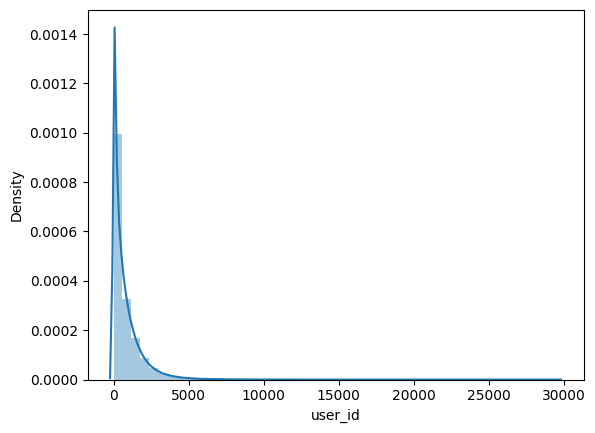

In [18]:
import seaborn as sns
sns.distplot(counts)

In [25]:
np.percentile(counts.to_numpy(), q=91)

2073.0